In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
retail = pd.read_csv('https://graderdata.s3.amazonaws.com/retailMarketingDI.csv')

In [3]:
retail.shape

(1000, 10)

- The table contains $1000$ rows of customer demographic information.
- Our goal is to:
     - build a customer-purchase-amounts descriptive model based on their demographics
     - figure out the important demographic features which contribute to the customer purchases. 

In [4]:
retail.columns

Index(['Age', 'Gender', 'OwnHome', 'Married', 'Location', 'Salary', 'Children',
       'History', 'Catalogs', 'AmountSpent'],
      dtype='object')

### Research Questions
- How do the customer incomes affect their retail spendings?
- How do the customer ages affect their retail spendings?
- Do the customer genders affect their retail spendings?
- Does the marriage status or having children or not affect customer spendings?
- Does the distance to the store location affects their spendings (probably through frequency of visits)?
- Does the purchase history's duration affect the customers' spendings (loyalty to the store)?
...

- We would try to answer these customer analytical questions through the lens of 
linear regression.
- Because the consumer expenditure is the central issue, our statistical analysis is centered 
around it.


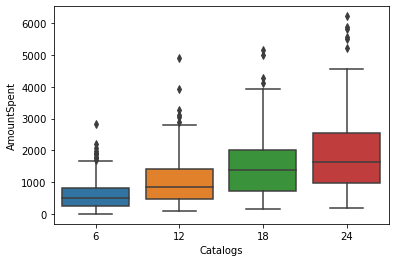

In [5]:
sns.boxplot(x='Catalogs', y='AmountSpent', data=retail)

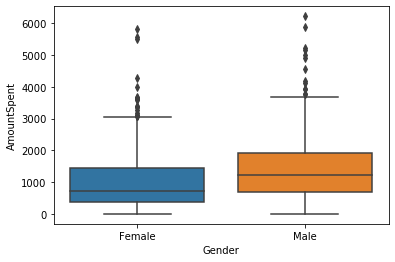

In [6]:
sns.boxplot(x='Gender', y='AmountSpent', data=retail)

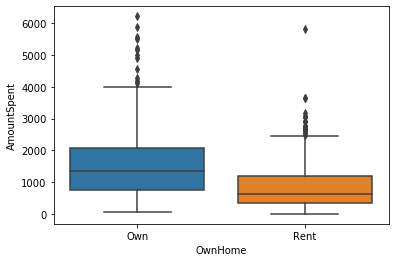

In [7]:
sns.boxplot(x='OwnHome', y='AmountSpent', data=retail)

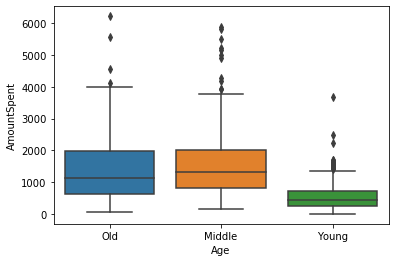

In [8]:
sns.boxplot(x='Age', y='AmountSpent', data=retail)

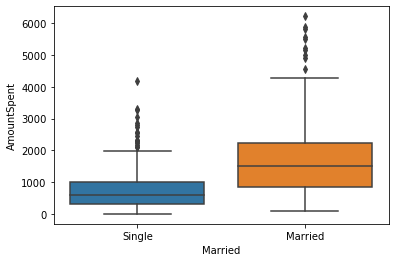

In [9]:
sns.boxplot(x='Married', y='AmountSpent', data=retail)

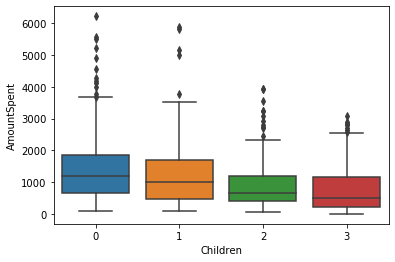

In [10]:
sns.boxplot(x='Children', y='AmountSpent', data=retail)

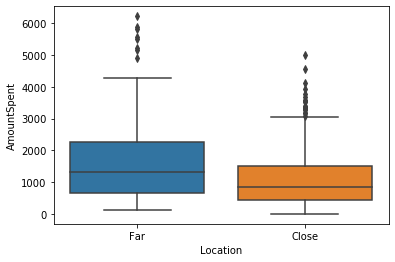

In [11]:
sns.boxplot(x='Location', y='AmountSpent', data=retail)

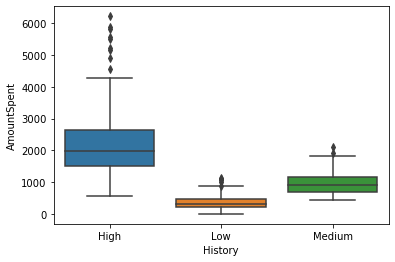

In [12]:
sns.boxplot(x='History', y='AmountSpent', data=retail)

- We notice that there are a large amount of outliers in the above boxplots! 
- The missing values of **History** is not displayed in this boxplot.

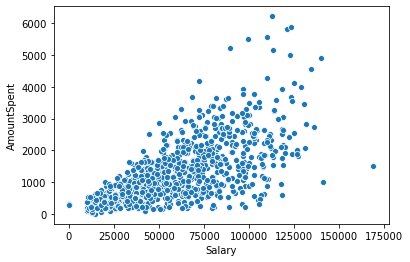

In [13]:
sns.scatterplot(x='Salary', y='AmountSpent', data=retail)

- The scatterplot between **Salary** and **AmountSpent** shows a funnel/fan-like pattern.
- It is true that higher paid customers have the potential to spend more. 
- But it shows a higher variability for high-income customers.
- Even though there is a linear trend between **Salary** vs **AmountPaid**, any line would be
a poor fit to the data, particularly on the high income region.
- On the other hand, the data points along any given straight line are from all the customers with
 a fixed AmountSpent/Salary ratio (i.e. expenditure percentage).
the fan-like pattern suggests that the customers can be grouped to different expenditure percentage
groups, while the straight lines through the origin rotate.


- The patterns displayed above are self-evident.
- All the categorical and continuous features are driving factors to the customer spendings.
- But one weakness of the naive unary **groupby** approach is that it does not control the other
factors which also contribute to spendings.
- For example, even though it is evident from the above boxplot that the senior customers tend to 
buy more, but it is not clear whether this is due to their ages, or it is because they tend to have
higher compensations.
- In order to analyze the driving factors to the customer spendings, we need to use machine learning, particularly 
the multiple linear regression model, to control the various confounding factors.

### Research Questions
- How to model the **fan-like** pattern effectively?
- How to account for the fact that the different customers have different 
**expenditure percentage**? What are the driving factors for the different slopes (in this context,
the slopes mean **expenditure percentages**)? How to model them?
- With the same incomes, why do some customers spend more than the others?
- We will formulate this using multiple linear regression.

### Investigate the Missing Values

In [14]:
retail.isnull().sum(axis=0)

Age              0
Gender           0
OwnHome          0
Married          0
Location         0
Salary           0
Children         0
History        303
Catalogs         0
AmountSpent      6
dtype: int64

In [15]:
(retail[['Salary', 'AmountSpent']] == 0).sum(axis=0)

Salary         3
AmountSpent    2
dtype: int64

### Finding Insights through Visualizing the Log-Log Scatter Plot

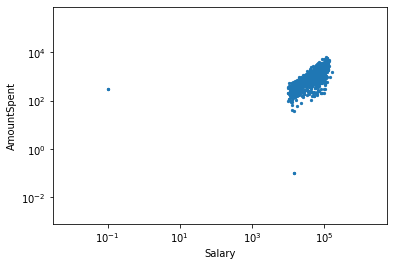

In [16]:
(retail[['Salary','AmountSpent']]+1e-1).plot(kind='scatter', x='Salary', \
                                           y='AmountSpent', logx=True, logy=True, s=5)

## Data Cleaning
- Because **AmountSpent** is the target variable we want to predict, it makes no sense
to impute the target variable.
We are forced to remove the $6$ rows with missing
**AmountSpent**.
- We notice that the log-log scatter plot (after adding $1\over 10$ to account for the vanishing
salary/amount spent) are two major outliers.  These outliers have to be 
removed in order for the linear
regression technique to function properly.
- Discarding these outliers, the fan-like pattern is converted into a band of parallel lines.
- We replace the missing **History** values by the 'Missing' token before further dummification.

In [17]:
retail2 = retail[retail[['Salary', 'AmountSpent']].isnull().sum(axis=1)==0].copy()
retail_vanishing = retail2[(retail2[['Salary', 'AmountSpent']]==0).any(axis=1)]
retail2 = retail2[(retail2[['Salary', 'AmountSpent']]!=0).all(axis=1)]
retail2.fillna('Missing', inplace=True)
retail2.shape   # all together 10 samples are removed.

(990, 10)

In [18]:
retail_vanishing  # these are the outliers which are not fed into the linear model

,Age,Gender,OwnHome,Married,Location,Salary,Children,History,Catalogs,AmountSpent
76,Young,Female,Rent,Married,Close,0,3,Low,12,307.0
187,Middle,Female,Rent,Single,Far,0,3,Low,6,292.0
385,Young,Male,Rent,Single,Close,14600,3,NaN,6,0.0
531,Young,Female,Rent,Single,Close,14600,3,Low,6,0.0


### Why Do The Log-Log Scatter Plot Provide a Better Regression Data Fit?

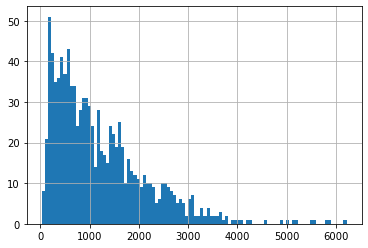

In [19]:
retail2.AmountSpent.hist(bins=100)

- The highly skew nature of the target **AmountSpent** is why there are
a lot of outliers in the boxplot analysis.
- The **skew** value indicates a positive skew value.

In [20]:
from scipy.stats import skew
skew(retail2.AmountSpent)

1.468168815398294

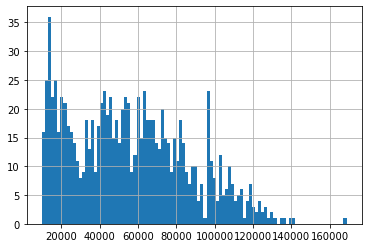

In [21]:
retail2.Salary.hist(bins=100)

In [22]:
skew(retail2.Salary)

0.41738694027343004

- The salaries of the retail customers show multiple peaks before decaying
above $80K$.  Again the distribution is slightly right-skewed. 
- The **skew** value is not as severe as **AmountSpent**.

### Obervations
- While **Salary** and **AmountSpent** have different ranges 
(up to $6K$ vs up to $160K$), both of them are skew toward the right.
- The **Salary** column seems to have multiple peaks.

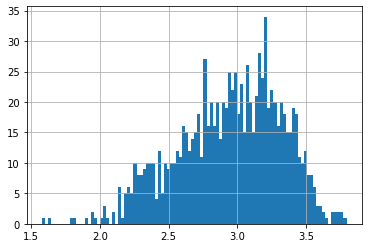

In [23]:
np.log10(retail2.AmountSpent).hist(bins=100)

In [24]:
skew(np.log10(retail2.AmountSpent))

-0.43330067610571704

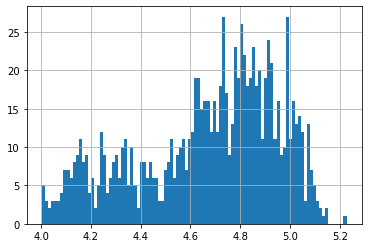

In [25]:
np.log10(retail2.Salary).hist(bins=100)

In [26]:
skew(np.log10(retail2.Salary))

-0.5786544559609359

- Taking log, up to a certain extent, over-corrects the skewnesses. 
- We will use linear regression to test the $R^2$ directly.

In [27]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(retail2[['Salary']], retail2['AmountSpent'])
print(lm.score(retail2[['Salary']], retail2['AmountSpent']))

0.48739439988430844


In [28]:
lm.fit(retail2[['Salary']], np.log10(retail2['AmountSpent']))
print(lm.score(retail2[['Salary']], np.log10(retail2['AmountSpent'])))

0.5180989224740675


In [29]:
lm.fit(np.log10(retail2[['Salary']]), np.log10(retail2['AmountSpent']))
print(lm.score(np.log10(retail2[['Salary']]), np.log10(retail2['AmountSpent'])))

0.58139912858998


- Apparently taking **log-log** transformation improves the model fit quality.
- While taking log does not improve **Salary** skewness, both **log(Salary)** and **log(AmountSpent)** having negative skewness 
make it easier to fit a proportional relationship. 
- From now on we will stick to the log-log version for linear regression analysis.

### Categorical Feature Dummification
- Next we dummify the categorical columns, 
dropping the dominant values as the base categories.
- **Children**, **Catalogs** are ordinal categorical. We choose not to 
dummify them because the boxplots hint that the number of children and the
number of catalogs seem to have linear impacts on the target **log(AmountSpent)**. 

In [30]:
X=retail2[['Age', 'Gender', 'OwnHome', 'Married', 'Location',
       'History']]  

In [31]:
features = [np.log10(retail2[['Salary']]), retail2[['Children']], retail2[['Catalogs']]]  # seed with the continuous feature

for name in X.columns:
    features.append(pd.get_dummies(X[name], prefix=name).drop(name+'_'+str(X[name].mode()[0]), axis=1))
    # dropping the dummified column with the highest frequency count (i.e. the mode)
    
features = pd.concat(features, axis=1) 
Y = np.log10(retail2.AmountSpent)

In [32]:
from sklearn.model_selection import train_test_split

features_train, features_test, Y_train, Y_test = train_test_split(features, Y, test_size=0.2)

In [33]:
lm.fit(features_train, Y_train)
lm.score(features_train, Y_train)

0.8757719388385669

In [34]:
lm.fit(features_test, Y_test)
lm.score(features_test, Y_test)

0.8693017101857655

In [35]:
lm.fit(features, Y)
lm.score(features, Y)

0.8725763741332728

In [36]:
print('The intercept is ', lm.intercept_)
pd.Series(lm.coef_, index=features.columns)

The intercept is  -1.1871824031323683


Salary            0.860318
Children         -0.080978
Catalogs          0.016523
Age_Old           0.009256
Age_Young        -0.002092
Gender_Male      -0.011420
OwnHome_Rent     -0.009278
Married_Single    0.013078
Location_Far      0.153379
History_High     -0.058283
History_Low      -0.244920
History_Medium   -0.124773
dtype: float64

- Some of the features have small regression slopes.
- For the categorical features, the regression slopes are the intercept jumps relative to the baselines.
- Particularly **Marriage_Single**, **OwnHome_Rent**, **Gender_Male**, **Age_Young** have relatively small intercept jumps compared to the baseline.
- We use **statsmodels** to see whether these regression coefficients are significant. 

In [37]:
import statsmodels.api as sm
features_add=sm.add_constant(features)
ols = sm.OLS(Y,features_add)
result = ols.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            AmountSpent   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     557.5
Date:                Thu, 23 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:17:52   Log-Likelihood:                 579.88
No. Observations:                 990   AIC:                            -1134.
Df Residuals:                     977   BIC:                            -1070.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.1872      0.166     -7.158      0.000      -1.513      -0.862
Salary             0.8603      0.034     25.417      0.000       0.794       0.927
Children          -0.0810      0.005    -15.927      0.000      -0.091      -0.071
Catalogs           0.0165      0.001     23.970      0.000       0.015       0.018
Age_Old            0.0093      0.014      0.684      0.494      -0.017       0.036
Age_Young         -0.0021      0.015     -0.138      0.890      -0.032       0.028
Gender_Male       -0.0114      0.009     -1.235      0.217      -0.030       0.007
OwnHome_Rent      -0.0093      0.010     -0.901      0.368      -0.029       0.011
Married_Single     0.0131      0.012      1.055      0.292      -0.011       0.037
Location_Far       0.1534      0.010     15.186      0.000       0.134       0.173
History_High      -0.0583      0.014     -4.098      0.000      -0.086      -0.030
History_Low       -0.2449      0.013    -18.229      0.000      -0.271      -0.219
History_Medium    -0.1248      0.013     -9.929      0.000      -0.149      -0.100
==============================================================================
Omnibus:                        4.378   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                4.235
Skew:                          -0.146   Prob(JB):                        0.120
Kurtosis:                       3.131   Cond. No.                         661.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Several Features Lose Their Significance
- It turns out that **Marriage**, **OwnHome**, **Gender**, **Age** lose their statistical significance after controlling the confrounding factors. 
- On the other hand, **Location**, **History**, **Salary**, **Children**, **Catalogs** remain important.
- This is in a strong contrast to the unary data aggregation approach without any control on the confrounding variables.
- We remove the non-significant factors and refit a simplified model.

In [38]:
X2=retail2[['Location', 'History']]

In [39]:
features_red = [np.log10(retail2[['Salary']]), retail2[['Children', 'Catalogs']]]  # seed the continuous feature

for name in X2.columns:
    features_red.append(pd.get_dummies(X2[name], prefix=name).drop(name+'_'+str(X2[name].mode()[0]), axis=1))
    # dropping the dummified column with the highest frequency count (i.e. the mode)
    
features_red = pd.concat(features_red, axis=1) 


In [40]:
lm.fit(features_red, Y)
lm.score(features_red, Y)

0.8718899990516111

In [41]:
coefs = pd.Series(lm.coef_, index=features_red.columns)
print('intrecept: %.4f' %(lm.intercept_))
coefs

intrecept: -1.1411


Salary            0.850067
Children         -0.082036
Catalogs          0.016491
Location_Far      0.152993
History_High     -0.056801
History_Low      -0.243102
History_Medium   -0.123509
dtype: float64

In [42]:
residual = Y-lm.predict(features_red)

0.13513480864346644


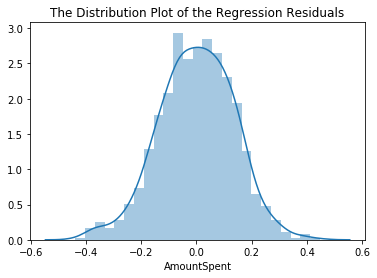

In [43]:
import seaborn as sns
sns.distplot(residual)
plt.title('The Distribution Plot of the Regression Residuals')
print(residual.std())

In [44]:
skew(residual)

-0.15806310452748926

In [45]:
features_red_add=sm.add_constant(features_red)
ols = sm.OLS(Y,features_red_add)
result_red = ols.fit()
result_red.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            AmountSpent   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     954.8
Date:                Thu, 23 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:17:52   Log-Likelihood:                 577.22
No. Observations:                 990   AIC:                            -1138.
Df Residuals:                     982   BIC:                            -1099.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.1411      0.097    -11.755      0.000      -1.332      -0.951
Salary             0.8501      0.021     40.436      0.000       0.809       0.891
Children          -0.0820      0.005    -17.474      0.000      -0.091      -0.073
Catalogs           0.0165      0.001     23.959      0.000       0.015       0.018
Location_Far       0.1530      0.010     15.161      0.000       0.133       0.173
History_High      -0.0568      0.014     -4.009      0.000      -0.085      -0.029
History_Low       -0.2431      0.013    -18.291      0.000      -0.269      -0.217
History_Medium    -0.1235      0.012     -9.954      0.000      -0.148      -0.099
==============================================================================
Omnibus:                        5.062   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                4.927
Skew:                          -0.158   Prob(JB):                       0.0851
Kurtosis:                       3.140   Cond. No.                         388.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### About the Information Criterions
- Even though the log-likelihood of the reduced model is slightly smaller, both
**AIC** and **BIC** are slightly lower (improved). This indicates (besides
the $R^2_{adj}$ based criterion) that we achieve a comparable result 
with less features.

### The Meaning of The log-linear Regression Model
- Fitting a machine learning/statistical learning model is the first step.
- It would be fruitless if our model does not enhance our understanding of the data or to
direct us to a better business practice. 
### What Insights Do We Gain?
- We observe that the customer income is the major driver of the customer expenditure. This factor
alone accounts for $58\%$ in terms of $R^2$ of the log-log linear-model.
- Controlling customer incomes, we find that the location factor, the number of children, the history
factor, the catalogs, all influence the customer expenditures significantly. They add about $30\%$
to the $R^2$.
- The farther the customer live, the more they spend in our site.
- The less children they have, the more they spend in our site.
- Reference to the missing value, all types of history show reduced spending.
The longer the history, the smaller the reduction.
- For the number of catalogs, the expenditure is montonically increasing w.r.t. the counts.
- In this framework, we have controlled the confrounding variables which may affect the customer spendings.
- We would like to study the meaning of the log-linear model.

- The log linear model can be written in a schematic form, 

$$log_{10}(Spending) = -1.14 + 0.85*log_{10}(Salary)-0.082*Children + 0.0165* Catalogs+DummifiedTerms + \epsilon,$$
where DummifiedTerms is the abbreviation of the sum of dummified intercept jumps and $\epsilon$
is the regression residual.

- If $0.85$ (the regression slope of the log-log regression) is replaced by $1$, 
we can recast the log-linear relationship into

$$log_{10}({Spending\over Salary}) = -1.14 -0.082*Children + 0.0165*Catalogs+ DummifiedTerms +\epsilon,$$
or equivalently 
$$ExpenditurePercentage={Spending\over Salary} = 
10^{-1.14}\cdot 10^{-0.082*Children+0.0165*Catalogs+DummifiedTerms + \epsilon}=
0.072*10^{\cdots + DummifiedTerm+\epsilon}.$$

### The Issue of Skewed Residuals
- When $\epsilon$ is approximtely normal, $10^{\epsilon}=e^{ln(10)*\epsilon}$ is skewed. 
While its mode (the peaks of pdf) is at $1$, its mean value is approximately
$1+{ln(10)\over 2}^2\sigma^2$ (ignoring the higher order terms).
- Here $\sigma$ is the standard deviation of the residuals, which is about $0.13$. So the 
mean value of the skewed random $e^{\epsilon}$ is about $1.044$.
- Taking into account that the log-log regression slope is $0.85$, we expect a relationship like
,
$$ExpendurePercentage = {0.072\over Salary^{0.15}}\cdot 10^{-0.082*Children+0.0165*Catalogs+DummifiedTerm+\epsilon}.$$

### From the Regression Slopes to the Expenditure Percentages
- The formula suggests that the estimated customer expenditure percentage for a customer
 who makes $50000$ annually, with no children, living close to our retail store, no history information,
    receiving no catalogs would on average spend $1.42\%$ of their salary in our store.
- When the annual income increases, the percentage would drop according to a power law.
- When the customer has children, or has a history with our store, or lives far away, ...., 
the expenditure percentage would need to adjust according to the following multiplicative schedule.
- For each $6$ catalogs the customer receives, it strengthens the **expenditurePercentage** by
a factor of $1.256$.
- For each additional child, it reduces the **expenditurePercentage** 
by a factor of $0.832$.
- If we make independent choices on the categorical **Location**, **History**, there
 are $8$ combinations. It blows up to $128$ combinations if we allow
the number of children and the catalogs to vary freely.
- For the illustration purpose, we display the 
**expenditure-percentage** curves with only one of the 
**Location** or **History** factors changing from the baseline.

In [46]:
10**coefs.iloc[3:]

Location_Far      1.422306
History_High      0.877403
History_Low       0.571344
History_Medium    0.752474
dtype: float64

In [47]:
exponents = coefs.iloc[3:].copy()
exponents['Baseline'] = 0
exponents

Location_Far      0.152993
History_High     -0.056801
History_Low      -0.243102
History_Medium   -0.123509
Baseline          0.000000
dtype: float64

Text(0.5, 1.0, 'The Expected Expenditure Percentages vs Incomes Plot')

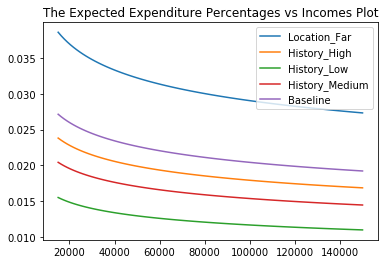

In [48]:
x = np.linspace(1.5e4, 1.5e5, 100)
x2= x.reshape(-1,1)
expenditure_percent = x2**(-0.15)*0.11*10**exponents.values.reshape(1,-1)*1.044
expenditure_percent = pd.DataFrame(expenditure_percent, columns=exponents.index, index=x)
out=expenditure_percent.plot()
plt.title("The Expected Expenditure Percentages vs Incomes Plot")

### Conclusion
- When the customer incomes increase, their expected spendings increase as well. 
- But higher consumer income induces a drop of the expenditure percentage, 
whose behavior is depicted in the above line plot.
- Once we forcast the expenditure percentage/per customer, we can output the customer expected spending.